In [194]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_lightning import seed_everything
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import os
from pathlib import Path
import shutil
import gzip
import requests
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
%matplotlib inline

# set seed 
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
seed_number = 42
seed = set_seed(seed_number)

Global seed set to 42


# load data

In [195]:
X_train = pd.read_feather('../data/X_train.feather')
y_train = pd.read_feather('../data/y_train.feather')
X_test = pd.read_feather('../data/X_test.feather')
y_test = pd.read_feather('../data/y_test.feather')
display(X_test.head())
display(y_test.head())

,shop_tag_2,shop_tag_6,shop_tag_10,shop_tag_12,shop_tag_13,shop_tag_15,shop_tag_18,shop_tag_19,shop_tag_21,shop_tag_22,shop_tag_25,shop_tag_26,shop_tag_36,shop_tag_37,shop_tag_39,shop_tag_48,chid,slam,age
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10485760.0,102382.569589,6.0
1,12289.330042,0.0,62643.191930,0.0,2688.055269,22366.738610,0.000000,0.000000,0.0,0.0,0.000000,0.000000,24893.333242,0.000000,0.000000,11900.190480,10485761.0,102382.569589,3.0
2,27038.812431,0.0,29267.566728,0.0,24586.212696,16555.646052,0.000000,0.000000,0.0,0.0,4404.325243,0.000000,23146.000680,8135.177708,0.000000,0.000000,10485762.0,44545.625512,3.0
3,52224.193152,0.0,0.000000,0.0,0.000000,22907.242157,7225.739353,0.000000,0.0,0.0,0.000000,41010.316376,0.000000,21842.333126,7945.887166,37032.778347,10485763.0,99935.984396,4.0
4,0.000000,0.0,0.000000,0.0,0.000000,9331.575338,0.000000,9277.143937,0.0,0.0,0.000000,0.000000,5773.036485,23295.245951,0.000000,0.000000,10485764.0,84815.219772,4.0


,top1,top2,top3
0,48,39,37
1,15,36,10
2,19,13,36
3,15,39,48
4,19,48,39


In [196]:
X_train.columns,y_train.columns

(Index(['shop_tag_2', 'shop_tag_6', 'shop_tag_10', 'shop_tag_12', 'shop_tag_13',
        'shop_tag_15', 'shop_tag_18', 'shop_tag_19', 'shop_tag_21',
        'shop_tag_22', 'shop_tag_25', 'shop_tag_26', 'shop_tag_36',
        'shop_tag_37', 'shop_tag_39', 'shop_tag_48', 'chid', 'slam', 'age'],
       dtype='object'),
 Index(['top1', 'top2', 'top3'], dtype='object'))

In [197]:
x_col = sorted(list(set(X_train.columns) - set(['chid'])))
y_col = list(set(y_train.columns) - set(['chid','top2','top3']))[0]
x_col,y_col

(['age',
  'shop_tag_10',
  'shop_tag_12',
  'shop_tag_13',
  'shop_tag_15',
  'shop_tag_18',
  'shop_tag_19',
  'shop_tag_2',
  'shop_tag_21',
  'shop_tag_22',
  'shop_tag_25',
  'shop_tag_26',
  'shop_tag_36',
  'shop_tag_37',
  'shop_tag_39',
  'shop_tag_48',
  'shop_tag_6',
  'slam'],
 'top1')

In [198]:
var = X_train[['age','slam']].describe()
var

,age,slam
count,415325.000000,4.011290e+05
mean,3.790013,1.533464e+105
std,1.262141,9.712157e+107
min,1.000000,8.019907e+03
25%,3.000000,5.970151e+04
50%,4.000000,7.687548e+04
75%,5.000000,1.014060e+05
max,9.000000,6.151170e+110


In [199]:
# fill na value
X_train['age'] = X_train['age'].fillna(var.loc['mean','age']) 
X_test['age'] = X_test['age'].fillna(var.loc['mean','age'])
X_train['slam'] = X_train['slam'].fillna(var.loc['mean','slam'])
X_test['slam'] = X_test['slam'].fillna(var.loc['mean','slam'])

In [200]:
for i in tqdm([X_train,X_test,y_train,y_test]):
    assert i.isnull().sum().sum() == 0

100%|██████████| 4/4 [00:00<00:00, 105.54it/s]


In [201]:
# min max scaler
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler().fit(X_train)
X_train.iloc[:,:] = mm.transform(X_train)
X_test.iloc[:,:] = mm.transform(X_test)

display(X_train.head())
display(X_test.head())

,shop_tag_2,shop_tag_6,shop_tag_10,shop_tag_12,shop_tag_13,shop_tag_15,shop_tag_18,shop_tag_19,shop_tag_21,shop_tag_22,shop_tag_25,shop_tag_26,shop_tag_36,shop_tag_37,shop_tag_39,shop_tag_48,chid,slam,age
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.971522,1.534060e-106,0.625
1,0.164972,0.0,0.363128,0.0,0.000000,0.151930,0.000000,0.000000,0.0,0.0,0.0,0.0,0.081819,0.000000,0.000000,0.074983,0.971524,1.534060e-106,0.250
2,0.062066,0.0,0.087918,0.0,0.220605,0.047140,0.022503,0.000000,0.0,0.0,0.0,0.0,0.090775,0.050124,0.000000,0.000000,0.971526,5.938012e-107,0.250
3,0.175119,0.0,0.000000,0.0,0.000000,0.109936,0.021494,0.000000,0.0,0.0,0.0,0.0,0.000000,0.158334,0.101065,0.251623,0.971528,1.494286e-106,0.375
4,0.000000,0.0,0.000000,0.0,0.000000,0.059574,0.000000,0.044748,0.0,0.0,0.0,0.0,0.000000,0.060254,0.000000,0.000000,0.971530,1.248467e-106,0.375


,shop_tag_2,shop_tag_6,shop_tag_10,shop_tag_12,shop_tag_13,shop_tag_15,shop_tag_18,shop_tag_19,shop_tag_21,shop_tag_22,shop_tag_25,shop_tag_26,shop_tag_36,shop_tag_37,shop_tag_39,shop_tag_48,chid,slam,age
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.971522,1.534060e-106,0.625
1,0.047796,0.0,0.297264,0.0,0.024332,0.121510,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.145040,0.000000,0.000000,0.074983,0.971524,1.534060e-106,0.250
2,0.105160,0.0,0.138885,0.0,0.222548,0.089940,0.000000,0.000000,0.0,0.0,0.035733,0.000000,0.134859,0.050124,0.000000,0.000000,0.971526,5.938012e-107,0.250
3,0.203112,0.0,0.000000,0.0,0.000000,0.124446,0.046712,0.000000,0.0,0.0,0.000000,0.210435,0.000000,0.134578,0.032882,0.233342,0.971528,1.494286e-106,0.375
4,0.000000,0.0,0.000000,0.0,0.000000,0.050695,0.000000,0.044748,0.0,0.0,0.000000,0.000000,0.033636,0.143530,0.000000,0.000000,0.971530,1.248467e-106,0.375


# Define categorical features for categorical embeddings

In [202]:
'''
unused_feat = ['index','shop_tag']
target = 'shop_tag'
categorical_columns = ['masts','educd','trdtp','naty','poscd','cuorg','gender_code','age','primary_card']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
cat_idxs
'''

"\nunused_feat = ['index','shop_tag']\ntarget = 'shop_tag'\ncategorical_columns = ['masts','educd','trdtp','naty','poscd','cuorg','gender_code','age','primary_card']\nfeatures = [ col for col in train.columns if col not in unused_feat+[target]] \ncat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]\ncat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]\ncat_idxs\n"

# Network parameters

In [203]:
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)
clf = TabNetClassifier(optimizer_fn=MADGRAD,optimizer_params=dict(lr=2e-2),device_name='cpu')

Device used : cpu


# Train

In [204]:
n = 9999
X_train = X_train[x_col].values[:n]
X_test = X_test[x_col].values[:n]
y_train = y_train[y_col].values[:n]
y_test = y_test[y_col].values[:n]
for i in tqdm([X_train,X_test,y_train,y_test]):
    print(i.shape)

100%|██████████| 4/4 [00:00<00:00, 4012.73it/s]

(9999, 18)
(9999, 18)
(9999,)
(9999,)


In [205]:
# fit model
X_valid, y_valid = X_test,y_test
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    max_epochs=250)

epoch 0  | loss: 3.5699  | train_accuracy: 0.07611 | valid_accuracy: 0.09171 |  0:00:01s
epoch 1  | loss: 3.00329 | train_accuracy: 0.24492 | valid_accuracy: 0.24092 |  0:00:02s
epoch 2  | loss: 2.68578 | train_accuracy: 0.24612 | valid_accuracy: 0.24142 |  0:00:04s
epoch 3  | loss: 2.48706 | train_accuracy: 0.24612 | valid_accuracy: 0.24142 |  0:00:05s
epoch 4  | loss: 2.35748 | train_accuracy: 0.24612 | valid_accuracy: 0.24142 |  0:00:06s
epoch 5  | loss: 2.27572 | train_accuracy: 0.24612 | valid_accuracy: 0.24142 |  0:00:08s
epoch 6  | loss: 2.22928 | train_accuracy: 0.24612 | valid_accuracy: 0.24142 |  0:00:09s
epoch 7  | loss: 2.19848 | train_accuracy: 0.24612 | valid_accuracy: 0.24142 |  0:00:10s
epoch 8  | loss: 2.17629 | train_accuracy: 0.24612 | valid_accuracy: 0.24142 |  0:00:12s
epoch 9  | loss: 2.15666 | train_accuracy: 0.24622 | valid_accuracy: 0.24152 |  0:00:13s
epoch 10 | loss: 2.14393 | train_accuracy: 0.24612 | valid_accuracy: 0.24152 |  0:00:14s
epoch 11 | loss: 2.11

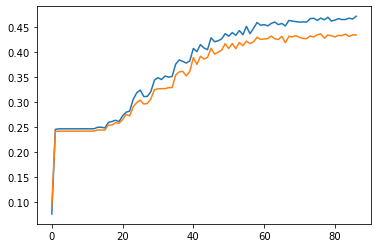

In [206]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

# Predictions

In [207]:
X_valid = X_test
y_valid = y_test
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
preds = clf.predict_proba(X_valid)
y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
valid_acc = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"BEST VALID SCORE FOR : {clf.best_cost}")
print(f"FINAL VALID SCORE FOR : {valid_acc}")

BEST VALID SCORE FOR : 0.43574357435743577
FINAL VALID SCORE FOR : 0.43574357435743577
